# Lab 06-2: Regularization for Deep Neural Networks
## Exercise: Predicting MNIST Digits
### For this exercise, prepare Lab 05-3 to copy your previous implementations.

### Prepare Mini-MNIST Dataset

In [54]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

digits = load_digits()

# digits.data from sklearn contains 1797 images of 8x8 pixels
# Each image has a hand-written digit
digits_df = digits.images.reshape((len(digits.target), -1))
digits_tf = digits.target

# Splitting dataframe into train & test
X_train_org, X_test_org, y_train_num, y_test = train_test_split(digits_df, digits_tf, test_size= 0.20, random_state= 101)

# Digits data has range of [0,16], which often lead too big exponential values
# so make them normal distribution of [0,1] with the sklearn package, or you can just divide them by 16
sc = StandardScaler()
X_train = sc.fit_transform(X_train_org)
X_test = sc.transform(X_test_org)

n_classes = 10

# Transform Nx1 Y vector into Nx10 answer vector, so that we can perform one-to-all classification
y_train = np.zeros((y_train_num.shape[0],10))
for i in range(n_classes):
    y_train[:,i] = (y_train_num == i)

Define Utility Functions

In [55]:
def sigmoid(x):
    # Numerically stable with large exponentials
    x = np.where(x < 0, np.exp(x)/(1 + np.exp(x)), 1/(1 + np.exp(-x)))
    return x

def softmax(x):
    # Numerically stable with large exponentials
    x = x - np.max(x, axis=-1, keepdims=True)
    x = np.exp(x)
    xs = np.sum(x, axis=-1, keepdims=True)
    return x / xs

def create_mini_batches(X, y, batch_size=64):
    # Another implementatioin example of creating mini-batches
    data = np.hstack((X, y))
    np.random.shuffle(data)
    X_batches, y_batches = np.split(data, (X.shape[1],), axis=1)
    X_mini = np.split(X_batches, np.arange(batch_size,len(X),batch_size), axis=0)
    y_mini = np.split(y_batches, np.arange(batch_size,len(X),batch_size), axis=0)
    mini_batches = zip(X_mini, y_mini)
    return mini_batches

(1797, 64)
(1437, 64)
(1437, 10)
[ 0.  0.  0.  9. 16.  6.  0.  0.  0.  0.  4. 15.  6. 15.  0.  0.  0.  0.
  8. 11.  9. 11.  0.  0.  0.  0.  8. 16. 14.  2.  0.  0.  0.  0. 11. 16.
 13.  0.  0.  0.  0.  6. 14.  2. 12.  9.  0.  0.  0.  5. 16. 11.  5. 13.
  4.  0.  0.  0.  3.  8. 13. 16.  9.  0.]


<Figure size 432x288 with 0 Axes>

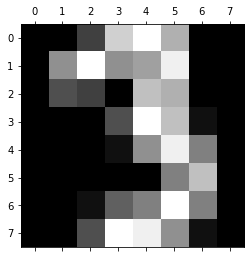

The number is 3


In [56]:
print(digits_df.shape)
print(X_train.shape)
print(y_train.shape)
print(X_train_org[0])

idx = np.random.randint(X_train.shape[0])
dimage = X_train_org[idx].reshape((8,8))
plt.gray()
plt.matshow(dimage)
plt.show()
print('The number is', y_train_num[idx])


### Simple DNN for Digit Classification

Define Model Class with a Dropout Mask<br>
Forward and Backward are same as before (<b>Exercise 05-3</b>)

In [57]:
class myNeuralLayer:
    def __init__(self, n_out, n_in):
        self.wegt = np.zeros((n_out, n_in))
        self.bias = np.zeros((n_out))
        self.mask = np.ones((n_out))

    def forward(self, x):       # (b, i)
        ### START CODE HERE ###

        x_lin = x @ self.wegt.T + self.bias            # Linear Prediction
        
        ### END CODE HERE ###
        return x_lin

    def backward(self, x, x_in):  # x = dJ/dz (b, c)
        ### START CODE HERE ###
        
        dw = x.T @ x_in / x.shape[0]               # Gradients for weights
        db = np.mean(x, axis=0)               # Gradients for biases
        wdJdz = x @ self.wegt            # Propagation for lower layer
        
        ### END CODE HERE ###
        return dw, db, wdJdz


Define Backpropagation of Activation Functions (<b>From the previous exercise 05-3</b>)

In [58]:
def dJdz_sigmoid(wdJdz_upper, az):
    ### START CODE HERE ###

    dJdz = wdJdz_upper * az * (1 - az)            # backpropagation through activation function

    ### END CODE HERE ###
    return dJdz

def dJdz_softmax(y_hat, y):
    ### START CODE HERE ###

    dJdz = y_hat - y            # backpropagation through activation function
    
    ### END CODE HERE ###
    return dJdz

### Define Training Functions<br>
<b>Dropout & l2 Regularization should be implemented here (Start from the code of exercise 05-3</b>)

In [59]:
def my_forward(l1, l2, l3, X_in, dropout=0.5):
    ### START CODE HERE ###

    a_1 = sigmoid(l1.forward(X_in))                    # first stage forward
    l1.mask = np.random.binomial(n=1, p=1-dropout, size=l1.mask.size)                # generate 1st stage mask
    a_2 = sigmoid(l2.forward(l1.mask * a_1 / (1 - dropout)))                    # masking & second stage forward
    l2.mask = np.random.binomial(n=1, p=1-dropout, size=l2.mask.size)                # generate 2nd stage mask
    a_3 = softmax(l3.forward(l2.mask * a_2 / (1 - dropout)))                    # masking & third stage forward

    ### END CODE HERE ###
    return a_1, a_2, a_3

def my_backward(l1, l2, l3, a_1, a_2, a_3, X_in, y_true, l2_lambda=1e-2):
    ### START CODE HERE ###

    dw_3, db_3, wdJdz_3 = l3.backward(dJdz_softmax(a_3, y_true), a_2)    # go through 3rd stage backward
    dw_3 = dw_3 + 2 * l2_lambda * l3.wegt                   # adjust for L2 regularization
    dw_2, db_2, wdJdz_2 = l2.backward(dJdz_sigmoid(wdJdz_3, a_2 * l2.mask), a_1)    # go through 2nd mask and 2nd stage backward
    dw_2 = dw_2 + 2 * l2_lambda * l2.wegt                   # adjust for L2 regularization
    dw_1, db_1, _       = l1.backward(dJdz_sigmoid(wdJdz_2, a_1 * l1.mask), X_in)    # go through 1st mask and 1st stage backward
    dw_1 = dw_1 + 2 * l2_lambda * l1.wegt                   # adjust for L2 regularization

    ### END CODE HERE ###
    d_1 = [dw_1, db_1]
    d_2 = [dw_2, db_2]
    d_3 = [dw_3, db_3]
    return d_1, d_2, d_3

def my_loss(l1, l2, l3, X_in, y_true):
    ### START CODE HERE ###

    a_1 = sigmoid(l1.forward(X_in))                    # first stage forward
    a_2 = sigmoid(l2.forward(a_1))                    # second stage forward
    a_3 = softmax(l3.forward(a_2))                    # third stage forward
    loss = -np.mean(y_true * np.log(a_3)) 

    ### END CODE HERE ###
    return loss
    
def my_predict(l1, l2, l3, X_in):
    ### START CODE HERE ###

    a_1 = sigmoid(l1.forward(X_in))                    # first stage forward
    a_2 = sigmoid(l2.forward(a_1))                    # second stage forward
    a_3 = softmax(l3.forward(a_2))                    # third stage forward
    pred = np.argmax(a_3, axis=1)                   # make prediction

    ### END CODE HERE ###
    return pred

Create a NN model and check the matrix dimensions

In [60]:
n_inputs  = 64
n_hidden1 = 80
n_hidden2 = 70
n_classes = 10

l1 = myNeuralLayer(n_hidden1, n_inputs)
l2 = myNeuralLayer(n_hidden2, n_hidden1)
l3 = myNeuralLayer(n_classes, n_hidden2)

print(X_train.shape, y_train.shape)
print(l1.wegt.shape, l1.bias.shape)
print(l2.wegt.shape, l2.bias.shape)
print(l3.wegt.shape, l3.bias.shape)

(1437, 64) (1437, 10)
(80, 64) (80,)
(70, 80) (70,)
(10, 70) (10,)


Weight Initialization

In [61]:
def my_initializer(lyr, pdf='normal'):   # probability density function
    (fan_out, fan_in) = w_shape = lyr.wegt.shape                # (c, i)
    if pdf=='normal':
        lyr.wegt = np.random.randn(*w_shape)
    elif pdf=='uniform':
        lyr.wegt = np.random.rand(*w_shape)
    elif pdf=='xavier_normal':           # Xavier is also known as Glorot
        lyr.wegt = np.random.randn(*w_shape) * np.sqrt(2/(fan_out + fan_in))
    elif pdf=='xavier_uniform':
        lyr.wegt = np.random.rand(*w_shape) * np.sqrt(6/(fan_out + fan_in))
    elif pdf=='he_normal':
        lyr.wegt = np.random.randn(*w_shape) * np.sqrt(2/fan_in)
    elif pdf=='he_uniform':
        lyr.wegt = np.random.rand(*w_shape) * np.sqrt(6/fan_in)
    else:
        print('initializer error')
    return

# Weights are initialized to...
weight_init = 'he_uniform'

my_initializer(l1, pdf=weight_init)
my_initializer(l2, pdf=weight_init)
my_initializer(l3, pdf=weight_init)

Define Optimizer; Mini-batch SGD only.

In [62]:
class myOptParam:
    def __init__(self, n_out, n_in):
        # Previoud delta values for momentum optimizer
        self.W_dt = np.zeros((n_out, n_in))
        self.B_dt = np.zeros(n_out)
        # Variables for other optimizers
        self.W_mt = np.zeros((n_out, n_in))
        self.B_mt = np.zeros(n_out)
        self.W_vt = np.zeros((n_out, n_in))
        self.B_vt = np.zeros(n_out)
        # Variable for Adam optimizer
        self.iter = 0

def my_optimizer(lyr, opt, W_grad, B_grad, solver='sgd', learning_rate=0.01, iter=0):
    epsilon = 1e-8  # arbitrary small number
    alpha = eta = learning_rate
    if iter!=0:
        opt.iter = iter

    # optimizer routines
    if  solver=='sgd':
        W_dlt = alpha * W_grad
        B_dlt = alpha * B_grad
    else:  
        print('optimizer error')

    # Adjust weight
    lyr.wegt = lyr.wegt - W_dlt
    lyr.bias = lyr.bias - B_dlt

    return

Create Optimizer Parameters

In [63]:
o1 = myOptParam(n_hidden1, n_inputs)
o2 = myOptParam(n_hidden2, n_hidden1)
o3 = myOptParam(n_classes, n_hidden2)

Training Simple Neural Network Model (3 layer model)

In [64]:
# optimizer settings are: 'sgd', 'momentum', 'adagrad', 'rmsprop', 'adam'
# alpha is learning rate
optimizer ='sgd'
alpha = 1e-1      # learning rate
lmbda = 1e-4      # l2 lambda
dpout = 0.2       # dropout rate
n_epochs = 1000

for epoch in range(n_epochs):

    batches = create_mini_batches(X_train, y_train, batch_size=64)
    for one_batch in batches:
        X_mini, y_mini = one_batch
        batch_len = X_mini.shape[0]  # last batch might have different length

        # Forward Path
        a_1, a_2, a_3 = my_forward(l1, l2, l3, X_mini, dropout=dpout)
        
        # Backward Path
        d_1, d_2, d_3 = my_backward(l1, l2, l3, a_1, a_2, a_3, X_mini, y_mini, l2_lambda=lmbda)

        dw_1, db_1 = d_1
        dw_2, db_2 = d_2
        dw_3, db_3 = d_3
    
        # Update weights and biases
        my_optimizer(l1, o1, dw_1, db_1, solver=optimizer, learning_rate=alpha)
        my_optimizer(l2, o2, dw_2, db_2, solver=optimizer, learning_rate=alpha)
        my_optimizer(l3, o3, dw_3, db_3, solver=optimizer, learning_rate=alpha)

    if ((epoch+1)%100==0):
        loss_J = my_loss(l1, l2, l3, X_train, y_train)
        print('Epoch: %4d,  loss: %10.8f' % (epoch+1, loss_J))

Epoch:  100,  loss: 0.24591380
Epoch:  200,  loss: 0.03937954
Epoch:  300,  loss: 0.00881832
Epoch:  400,  loss: 0.00439766
Epoch:  500,  loss: 0.00246616
Epoch:  600,  loss: 0.00162111
Epoch:  700,  loss: 0.00110960
Epoch:  800,  loss: 0.00073894
Epoch:  900,  loss: 0.00065133
Epoch: 1000,  loss: 0.00048733


Evaluate Model Performance

In [65]:
from sklearn.metrics import accuracy_score

y_pred = my_predict(l1, l2, l3, X_test)

accuracy_score(y_pred, y_test)

0.9805555555555555

Neural Network from scikit-learn

In [66]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(80, 70, ), activation='logistic', solver='sgd', \
                    alpha=0.01, learning_rate_init=0.01, max_iter=1000)

# Training/Fitting the Model
mlp.fit(X_train, y_train_num)

# Making Predictions
s_pred = mlp.predict(X_test)
accuracy_score(s_pred, y_test)

0.975

### Test Model with a random sample


<Figure size 432x288 with 0 Axes>

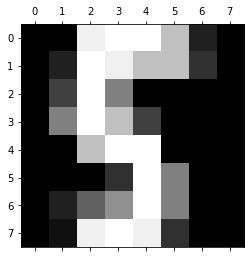

My prediction is 5
sk prediction is 5
Actual number is 5


In [67]:
idx = np.random.randint(X_test.shape[0])
dimage = X_test_org[idx].reshape((8,8))
plt.gray()
plt.matshow(dimage)
plt.show()

X_input = np.expand_dims(X_test[idx], 0)

y_pred = my_predict(l1, l2, l3, X_input)

s_pred = mlp.predict(X_input)

print('My prediction is ' + str(y_pred[0]))
print('sk prediction is ' + str(s_pred[0]))
print('Actual number is ' + str(y_test[idx]))
